In [13]:
"""
This is the ML model using neural networks. Creates preceptron units as class
@author Bala Bathula
Some of the code is borrowed from: https://rolisz.ro/2013/04/18/neural-networks-in-python/
This NN takes the bias unit at each layer
"""


import pandas as pd
import os

# Load the dataset

def get_data(train=True,base_dir='./data'):
    """
    This function gets the train/test data. By default the train=True. If train=False, then the test data would be returned
    output is a dataframe (train or test)
    """
    
    if train==True:
        return pd.read_csv(os.path.join(base_dir,'train.csv'))
        #return pd.read_csv(os.path.join(base_dir,'ex3_data.csv')) # Use this for Coursera excercise
    else:
        return pd.read_csv(os.path.join(base_dir,'test.csv'))


In [8]:
import numpy as np
import sys

def sigmoid(x):
    return 1.0/(1+np.exp(-x))

def derivative_sigmoid(x):
    return sigmoid(x)*(1-sigmoid(x))

def tanh(x):
    return np.tanh(x)

def derivative_tanh(x):
    return 1.0 - np.tanh(x)**2

class NeuralNetwork:
    """
    This class models an artificial neuron with a function that can be either sigmoid, or tanh
    Default activation unit is tanh
    Layer size in the number of activation units in each layer (including the input and output layer)
    # Warning: Layer size does not include the bias element. For instance if the there are 10 activation units, then total is 10+1 (+1 for bias)
    """
    
    def __init__(self, layer_size = np.array([1]),activation='tanh'):
        """
        Initialize weights based on input arguments. Note that no type-checking
        is being performed here for simplicity of code.
        """
        
        # Hidden layer size represents number of activation units in each layer
        nbr_of_layers=len(layer_size); # This is number of hidden layers that network should have
        
        # Initializing weights to zero, does not work in neural networks. Because when using the back-propagation, all nodes will update to the same value.
        # Choosing initial weights for improving the performance of the NN we use a method described in http://web.stanford.edu/class/ee373b/nninitialization.pdf
        # Refer to the ML-Coursera Wiki notes on NN for initialization 
        # Note that in a usual NN all the hidden layers will have the same size. So we have we choose  denominator as layer_size[1]
        # epsilon = sqrt(6/(Linput+Loutput)), where Loutput=number of units in hidden-layer
        # epsilon=(6.0/(layer_size[0]+layer_size[1]))**(1.0/2)
        epsilon=0.12
        # print epsilon
        self.weights=[] # Choose weights based on uniform distribution between [-epsilon, epsilon]
        
        # Add bias units to the weights except the last layer
        for lyr in range(0,nbr_of_layers-1):
            # Take the number of rows from the previous layer
            # TODO: need to check this initialization from Coursera
            # self.weights.append(np.random.random((layer_size[lyr]+1,layer_size[lyr+1]))*2*epsilon-epsilon) # .random((x,y)) gives uniformly distributed RVs between 0, 1 of size (x,y)
            #self.weights.append((2*np.random.random((layer_size[lyr]+1,layer_size[lyr+1]))-1)*0.25) # Initialize the weights randomly between -0.25 and 0.25
            self.weights.append(np.random.normal(0.0, layer_size[lyr]**-0.5, (layer_size[lyr]+1, layer_size[lyr+1]))) # There is no bias unit in this one

        if activation=='sigmoid':
            self.activation=sigmoid # Chooses the activation function
            self.activation_derivative=derivative_sigmoid #  derivative of sigmoid function
        elif activation=='tanh':
            self.activation=tanh # Tanh function
            self.activation_derivative=derivative_tanh # derivative tanh function
        
        
        self.last_input = 0 # strength of last input
        self.delta      = 0 # error signal
        

    def activate(self, values):
        """
        Takes in @param values, a list of numbers equal to length of weights.
        @return the list of activation units for all layers for a chosen activation function
        This is using feed-forward propagation method
        """
        # If there are more than one layer, then we need to do a for-loop
        self.last_input = values
        all_activation_units=[values]; # Don't use self.last_input values here; As self.last_input is mutable, change in self.last_input might change activation units 
        for i in range(len(self.weights)):
            
            # First take the dot product of weights and values
            strength = np.dot(self.last_input, self.weights[i])
            
            # Second pass the dot product to the activation unit
            
            self.last_input = self.activation(strength);
            
            # Third add the bias-units for the last_input along all rows (i.e., bias unit of column matrix)
            if i!=len(self.weights)-1: # Do not add the bias-unit for the last layer in the network, which is y^
                self.last_input=np.concatenate((np.ones((self.last_input.shape[0],1)),self.last_input),axis=1)
            # Append the activation units of each layer
            all_activation_units.append(self.last_input)
            
        
        result=all_activation_units
        
        return result
    
    def update(self, values, train, eta=.1):
        """
        Takes the values as activation units and true values of y as train. Updates internal weights according to gradient descent using
        these values and an optional learning rate, @param eta.
        Values: activation units ()
        train: y_true values
        eta: learning rate
        Updating the weights for multi-layer perceptron units has to be done using the back-propagation method
        """
        # before using the values[-1] we need to reshape either values or train to np.reshape(values,(m,n)) or np.reshape(train,(m,n)) to broadcast correctly
        # Here I choose to reshape train (which is nothing but y, this work especially, if you have more than one data point)
        train=np.reshape(train,(train.shape[0],train.shape[1])) # This might be redunant for some cases
        
        # Error in the prediction is
        error=train-values[-1];
        
        # Initialize the delta
        self.delta = error
                
        # Elements in all_delta_units are small delta and they should be column matrices. (without bias units for hidden layers)
        all_delta_units=[error*self.activation_derivative(values[-1])]; # Number of delta units at each layer are same as that of activation units, but without bias terms. Bias errors does not propagate
                  
        # First compute small deltas
        for l in range(len(values)-2,0,-1):
            self.delta=all_delta_units[-1].dot(self.weights[l].T)*(self.activation_derivative(values[l]))
            self.delta=self.delta[:,1:]; # Drop the bias units 
            all_delta_units.append(self.delta)
                    
        # Reverse the all_delta_units array
        all_delta_units.reverse()
        
        # Before computing big delta, take transpose of small deltas in each layer
        # all_delta_units=[i.T for i in all_delta_units]
                
        # Compute the big-deltas, matrix size of big-delta should be same as weights matrix size 
        
        for i in range(len(self.weights)):    
            delta_w=np.atleast_2d(values[i].T.dot(all_delta_units[i])); # Just to make the output is 2d array
            # (rw,cw)=self.weights[i].shape
            #delta_w=np.reshape(delta_w,(rw,cw)) # As we know big-delta size should be same as weights, using reshape make sure the matrices are of same size
            self.weights[i] += eta * delta_w/train.shape[0]
     
    def fit(self,X,y,lmbda=0.1,epochs=10000): # lmbda is the training rate (sometimes referred as eta)
        """
        Takes X and y as the input arguments. lmbda and epochs are optional (learning rates and number of iterations)
        Using stochastic gradient descent computes the updates to the weights and does the back-propagation.
        X does not have any bias units, but the activation function of the class updates X with bias units
        """
        
        for k in range(epochs):
            # For each epoch using feed-forward propagation compute the activation units for the given weights
            a=self.activate(X); # a is the list of arrays
            # Update the weights based on the activation units
            self.update(a,y,lmbda)
            sys.stdout.write("\rProgress: {:2.1f}".format(100 * k/float(epochs)))
            sys.stdout.flush()
     
    def predict(self, X):
        # after the fit function is called, you get the final weights, use that final weights to get a (activation units) and then get 'y_pred=a[-1]'
        
        a = self.activate(X)
        
        
        return a[-1]
       

def test():
    """
    Run few test cases to see if the Neural network works as we intended for it to work
    This test case is for XOR.
    """  
    
    X = np.array([[0, 0], [0, 1], [1, 0], [1, 1]]) # There are four data points in this
    y = np.array([[0], [1], [1], [0]]) # y should be a column array
    
    # Assume layer size does not include the bias unit
    layer_size=[X.shape[1],2,1]; # This is number of activation units in each  layer in the neural network should have; length of this is nothing but the number of layers
    
    # Concatenate ones to the input matrix (this is for the bias unit)
    X=np.concatenate((np.ones((X.shape[0],1)),X),axis=1)
    
    u1 = NeuralNetwork(layer_size=layer_size,)
    u1.fit(X,y,epochs=1000)
    y_pred=u1.predict(X)
    
    return y_pred 


Progress: 100.0[[ 0.00142528]
 [ 0.99670737]
 [ 0.99672086]
 [ 0.00162224]]


In [14]:
def digit_data_set_sklearn():
    """
    Test the neural network for digit data set of sklearn
    """
    from sklearn.model_selection import train_test_split # Cross-validation has been moved to model_selection in 0.20 version
    from sklearn.datasets import load_digits
    from sklearn.metrics import confusion_matrix, classification_report
    import os
    import pandas as pd
    
    import matplotlib.pyplot as plt 
    
     
    # View the digits
    digits = load_digits()
    plt.gray() 
    plt.matshow(digits.images[0]) 
    plt.show()
    
    # Start load the data
    X = digits.data
    y = digits.target
    X -= X.min() # normalize the values to bring them into the range 0-1
    X /= X.max()
    
    num_labels=10; # 0,1,2,...,9
    layer_size=[X.shape[1],100,num_labels]; # Since there are 10 labels, last layer has 10 outputs, so y should be a matrix of (X.shape[0],num_labels)
    
    nn = NeuralNetwork(layer_size,'tanh')
    
    # Concatenate ones to the input matrix (this is for the bias unit)
    X=np.concatenate((np.ones((X.shape[0],1)),X),axis=1)
    
    # Split the dataset into train and test sets
    
    X_train,X_test,y_train,y_test=train_test_split(X,y)
    
    
    # We can also used labelBinarizer of sklearn instead of below logical array
    y_train_labeled_matrix=np.zeros((X_train.shape[0],num_labels))
    y_test_labeled_matrix=np.zeros((X_test.shape[0],num_labels))
    
    for c in range(0,num_labels):
        y_train_bool=(y_train==c).astype(int) # Create an 1d array
        y_train_labeled_matrix[:,c]=y_train_bool;
        # Similarly for test set
        y_test_bool=(y_test==c).astype(int) # Create an 1d array
        y_test_labeled_matrix[:,c]=y_test_bool;
    
    nbr_epochs=10000
    nn.fit(X_train,y_train_labeled_matrix,epochs=nbr_epochs)
    
    y_train_pred_prob=nn.predict(X_train); # Shape of y_pred_prob is same that of y_labeled_matrix. This is probability of the data to be identified as a digit
    
    print (y_train_pred_prob)
    
    outdir='results'
    try:
        os.makedirs(outdir)
    except:
        pass
    
    np.savetxt('./%s/nn_prob_sklearn_digit_.csv'%(outdir),y_train_pred_prob,delimiter=',')
    
    train_pred_digits=np.argmax(y_train_pred_prob,axis=1)
    
    
    np.savetxt('./%s/nn_train_sklearn_digit_.csv'%(outdir),train_pred_digits,delimiter=',')
    print(train_pred_digits.shape)
    
    print("Training set accuracy: {0}".format(np.mean(train_pred_digits==y_train)*100))
    
    # Get the test set prediction
    y_test_pred_prob=nn.predict(X_test)
    test_pred_digits=np.argmax(y_test_pred_prob,axis=1)
    
    df_test_pred=pd.DataFrame(test_pred_digits,index=range(1,test_pred_digits.shape[0]+1),columns=['Label'])
    df_test_pred.index.names=['ImageId']
    
    df_test_pred.to_csv('%s/nn_test_results_%d_sklearn_digit_.csv'%(outdir,nbr_epochs))
    
    print (confusion_matrix(y_test,test_pred_digits))
    print (classification_report(y_test,test_pred_digits))
    
        
    return


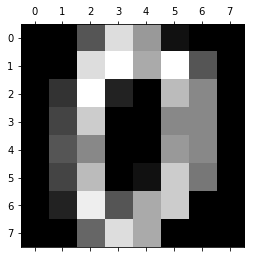

Progress: 100.0[[-0.06965261  0.16897833 -0.00138125 ..., -0.00263079  0.21398317
  -0.11303368]
 [-0.09796091 -0.00133879 -0.0090153  ..., -0.15989643  0.02283692
   0.06653438]
 [-0.060233    0.20332574 -0.07882075 ..., -0.01939499  0.88046216
  -0.23148222]
 ..., 
 [-0.08788308  0.09042691 -0.11542168 ...,  0.01154851  0.04615755
  -0.12471681]
 [-0.0273582   0.22603051 -0.13605809 ..., -0.03525684  0.83906127
  -0.21837863]
 [-0.11258263  0.9000396   0.07291809 ..., -0.08265999  0.01616933
   0.00422702]]
(1347,)
Training set accuracy: 98.51521900519673
[[46  0  0  0  0  0  0  0  0  0]
 [ 0 42  0  0  0  0  0  0  0  0]
 [ 0  0 45  0  0  0  0  0  0  0]
 [ 0  0  0 43  0  0  0  0  1  0]
 [ 0  0  0  0 57  0  0  0  0  0]
 [ 0  0  0  0  1 40  0  0  1  2]
 [ 0  1  0  0  0  0 38  0  0  0]
 [ 0  0  0  0  0  0  0 47  1  0]
 [ 0  1  0  0  0  0  0  0 40  0]
 [ 0  0  0  0  0  1  0  0  3 40]]
             precision    recall  f1-score   support

          0       1.00      1.00      1.00        4

In [15]:
digit_data_set_sklearn()